# Catboost Modelling

In this notebook, a final sales forecasting model based on the CatBoost algorithm is created. More information can be found here: https://catboost.ai/

Just as the Random Forest model, the final model is also a tree-based model. These types of algorithms lend themselves well to predicting target features that are not normally distributed, as is the case with sales here. Moreover, CatBoost is specifically tailored to datasets with many categorical variables. With the expception of weather and lag variables, this dataset mainly contains categorical features, including dummy variables.

Given the flexibility of CatBoost, no additional preprocessing is necessary. It can handle object (categorical) variables, missing values and responds well to non-normally distributed target variables.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as md
from matplotlib.patches import Patch
import seaborn as sns
import datetime as dt

from sklearn.impute import SimpleImputer, KNNImputer 
from sklearn.preprocessing import OneHotEncoder, RobustScaler, FunctionTransformer, PolynomialFeatures, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_squared_error

from sklearn.model_selection import TimeSeriesSplit, StratifiedKFold
from statsmodels.tsa.stattools import adfuller

from catboost import CatBoostRegressor
import catboost as cb
import optuna 

s:\Repos\sweet-spot-donut-sales-forecasting\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%run functions_model.py
%run functions_vis.py

In [3]:
pd.set_option("display.max_columns", None)

### Loading the dataset

In [4]:
d = pd.read_csv("data/train_df.csv")
d_test = pd.read_csv("data/test_df.csv")

In [5]:
d['date'] = pd.to_datetime(d['date'])
d_test['date'] = pd.to_datetime(d_test['date'])

### Creating validation dataset

A validation set, containing the last 7 days of the entire training dataset, is created. The validation set is used for evaluation purposes and early stopping in the CatBoost model.

In [6]:
train, val = create_val_set(d)

## Modelling

#### Selecting features

In order for the CatBoost algorithm to recognize categorical features, all variables are saved either as categorical or numerical. The date variable will serve as the index, while the lag features will only be used in the training and validation, but not the test dataset.

In [7]:
date = ["date"]

catfeat = ["store_name","item_category","hol_pub","hol_school","weekday","day","month","year","week_year","nye","valentines_day","halloween", "street_market","public_space","box_deal"]

numfeat = ["days_back","temperature_2m_mean","sunshine_duration","precipitation_hours"]

lag = ["lag1","lag2", "lag7"]

Two types of sets were created:

1. The first type of train, validation and test datasets contains all features at the day, store and product level. 
2. The second type contains all features only at the day and store level. The different product categories were removed and **only total daily sales** per store are kept.

In [8]:
x_train = train[date + catfeat + numfeat + lag]
x_train = x_train.set_index("date")
x_train_daily = x_train[(x_train["item_category"] == "daily total")].drop("item_category", axis = 1)
y_train = train['total_amount']
y_train_daily = train[(train["item_category"] == "daily total")]['total_amount']

x_val = val[date + catfeat + numfeat + lag]
x_val = x_val.set_index("date")
x_val_daily = x_val[(x_val["item_category"] == "daily total")].drop("item_category", axis = 1)
y_val = val['total_amount']
y_val_daily = val[(val["item_category"] == "daily total") ]['total_amount']

x_test = d_test[date + catfeat + numfeat]
x_test = x_test.set_index("date")
x_test_daily = x_test[(x_test["item_category"] == "daily total")].drop("item_category", axis = 1)
y_test = d_test['total_amount']
y_test_daily = d_test[(d_test["item_category"] == "daily total")]['total_amount']

In [25]:
#catfeat.remove("item_category")

#### Converting holiday features to integer

In [9]:
x_train["hol_pub"] = x_train["hol_pub"].apply(np.int64)
x_train["hol_school"] = x_train["hol_school"].apply(np.int64)
x_train_daily["hol_pub"] = x_train_daily["hol_pub"].apply(np.int64)
x_train_daily["hol_school"] = x_train_daily["hol_school"].apply(np.int64)

x_val["hol_pub"] = x_val["hol_pub"].apply(np.int64)
x_val["hol_school"] = x_val["hol_school"].apply(np.int64)
x_val_daily["hol_pub"] = x_val_daily["hol_pub"].apply(np.int64)
x_val_daily["hol_school"] = x_val_daily["hol_school"].apply(np.int64)

x_test["hol_pub"] = x_test["hol_pub"].apply(np.int64)
x_test["hol_school"] = x_test["hol_school"].apply(np.int64)
x_test_daily["hol_pub"] = x_test_daily["hol_pub"].apply(np.int64)
x_test_daily["hol_school"] = x_test_daily["hol_school"].apply(np.int64)

The train and target variables are concatenated to obtain a train and test set at the daily sales level, without the individual product categories.

In [10]:
train_daily = pd.concat([x_train_daily.reset_index(), y_train_daily.reset_index(drop= True)], axis = 1)

test_daily = pd.concat([x_test_daily.reset_index(), y_test_daily.reset_index(drop= True)], axis = 1)

### Custom CV split

In [ ]:
def create_train_validation_folds(df):
    last_val_date = df.date.max()
    cv = []
    for n in range(5):
        first_val_date = last_val_date - dt.timedelta(days=6)
        train_index = df[df.date<first_val_date].index
        val_index = df[(df.date>=first_val_date) & (df.date<=last_val_date)].index
        cv.append((train_index,val_index))
        last_val_date = first_val_date - dt.timedelta(days=1)
    cv = cv[::-1]
    return cv

In [ ]:
create_train_validation_folds(train_daily)

In [ ]:
def create_train_validation_dataset(df):
    last_val_date = df.date.max()
    cv = []
    for n in range(5):
        first_val_date = last_val_date - dt.timedelta(days=6)
        train_fold = df[df.date<first_val_date]
        val_fold = df[(df.date>=first_val_date) & (df.date<=last_val_date)]
        cv.append((train_fold,val_fold))
        last_val_date = first_val_date - dt.timedelta(days=1)
    cv = cv[::-1]
    return cv

In [ ]:
for i in range(5):
  globals()[f"train_{i}"], globals()[f"val_{i}"] = create_train_validation_dataset(train_daily)[i]

In [ ]:
val_4.head()

In [ ]:
train_val_datasets = [
    ("0", train_0, val_0),
    ("1", train_1, val_1),
    ("2", train_2, val_2),
    ("3", train_3, val_3),
    ("4", train_4, val_4)
]

In [ ]:
for set, train, val:

### Hyperparameter Tuning


Training tree-based algorithm often leads to overfitting. In order to create a generalizable model, it is necessary to "prune" the trees by putting constraints on how well they can learn from the data. The following hyperparameters are tuned in the step below:

* Number of trees
* Learning rate
* L2 leaf regularization
* Tree depth (number of levels)
* Proportion of the sample used for each tree
* Proportion of the features used for each tree
* A minimum amount of datapoints in a leaf before a split can occur
* Minimum child weight


In [11]:
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection import ForecastingRandomizedSearchCV
from sktime.split import ExpandingWindowSplitter
from sktime.utils import plot_windows
from sktime.utils._testing.hierarchical import _make_hierarchical
from sktime.transformations.series.summarize import WindowSummarizer

In [12]:
#fh = ForecastingHorizon(pd.period_range(start = '2024-05-11 00:00:00', periods = 7), is_relative=False)
fh = np.arange(7) + 1
fh

array([1, 2, 3, 4, 5, 6, 7])

In [13]:
train_2 = train[date + catfeat + numfeat]
train_2 = train_2[train_2["item_category"] != "daily total"]
train_2 = pd.concat([train_2, train[train["item_category"] != "daily total"]["total_amount"]], axis = 1)

In [14]:
agg_columns = train_2.columns.difference(['date', 'store_name', 'item_category'] + ["total_amount"])
agg_dict = {col: "first" for col in agg_columns}
agg_dict["total_amount"] = "sum"

train_2 = train_2.groupby(['date', 'store_name', 'item_category']).agg(agg_dict).reset_index().sort_values(by = "date", ascending = False).reset_index(drop = True)
train_2 = train_2.set_index(["store_name","item_category","date"]).sort_index()


kwargs = {"lag_feature": {
    "lag":[1,2,3],
    "mean": [[1,7], [1, 15], [1,30]],
    "std": [[1,4]]
    }, 
    "target_cols":["total_amount"]}
transformer = WindowSummarizer(**kwargs)
train_2_wind = transformer.fit_transform(train_2)
train_2_wind = pd.concat([train_2["total_amount"], train_2_wind], axis = 1)
train_2_wind = train_2_wind.dropna()

x_train_2_wind = train_2_wind.iloc[:,8:]
y_train_2_wind = train_2_wind.iloc[:,:8]

**Cross-validation**

In [154]:

def get_initial_window_size(store_group, validation_length, num_folds):
    total_periods = len(store_group.index.get_level_values('date').unique())
    initial_window = total_periods - validation_length * num_folds
    return initial_window

cv_list = []

for (store, item_category), group in train_2_wind.groupby(level=['store_name', 'item_category']):
    
    # Calculate the initial window size for the current store
    initial_window = get_initial_window_size(group, validation_length = 7, num_folds = 5)
    
    # Initialize the ExpandingWindowSplitter for the current group
    splitter = ExpandingWindowSplitter(
        initial_window=initial_window,
        step_length=7,
        fh=list(range(1, 7 + 1))
    )

    cv_list.append(({f"{store}"+"_"+f"{item_category}":splitter},
                        {f"{store}"+"_"+f"{item_category}":group}))


In [30]:
def plot_wind(y, train_windows, test_windows, title=""):
    """Visualize training and test windows"""

    def get_y(length, split):
        # Create a constant vector based on the split for y-axis."""
        return np.ones(length) * split

    n_splits = len(train_windows)
    n_timepoints = len(y)
    len_test = len(test_windows[0])

    train_color, test_color = sns.color_palette("colorblind")[:2]

    fig, ax = plt.subplots(figsize=plt.figaspect(0.3))

    for i in range(n_splits):
        train = train_windows[i]
        test = test_windows[i]

        ax.plot(
            np.arange(n_timepoints), get_y(n_timepoints, i), marker="o", c="lightgray"
        )
        ax.plot(
            train,
            get_y(len(train), i),
            marker="o",
            c=train_color,
            label="Window",
        )
        ax.plot(
            test,
            get_y(len_test, i),
            marker="o",
            c=test_color,
            label="Forecasting horizon",
        )
    ax.invert_yaxis()
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set(
        title=title,
        ylabel="Window number",
        xlabel="Time",
        #xticks = y.index.get_level_values("date")
        xticklabels=y.index.get_level_values("date")
    )
    # remove duplicate labels/handles
    handles, labels = [(leg[:2]) for leg in ax.get_legend_handles_labels()]
    ax.legend(handles, labels, bbox_to_anchor = (1, 0.25))

In [429]:
from matplotlib.ticker import MaxNLocator

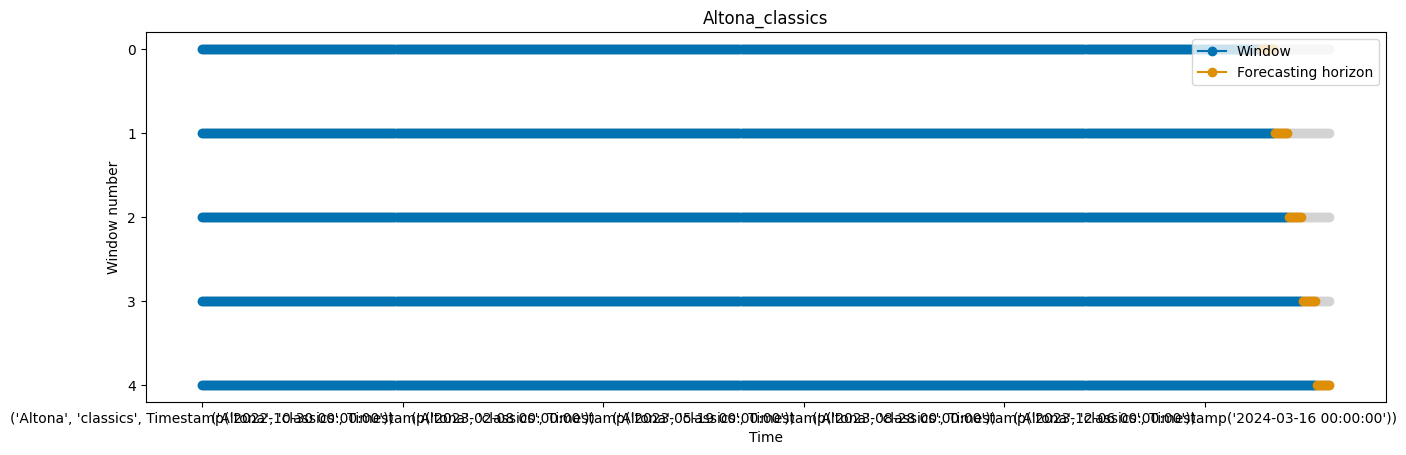

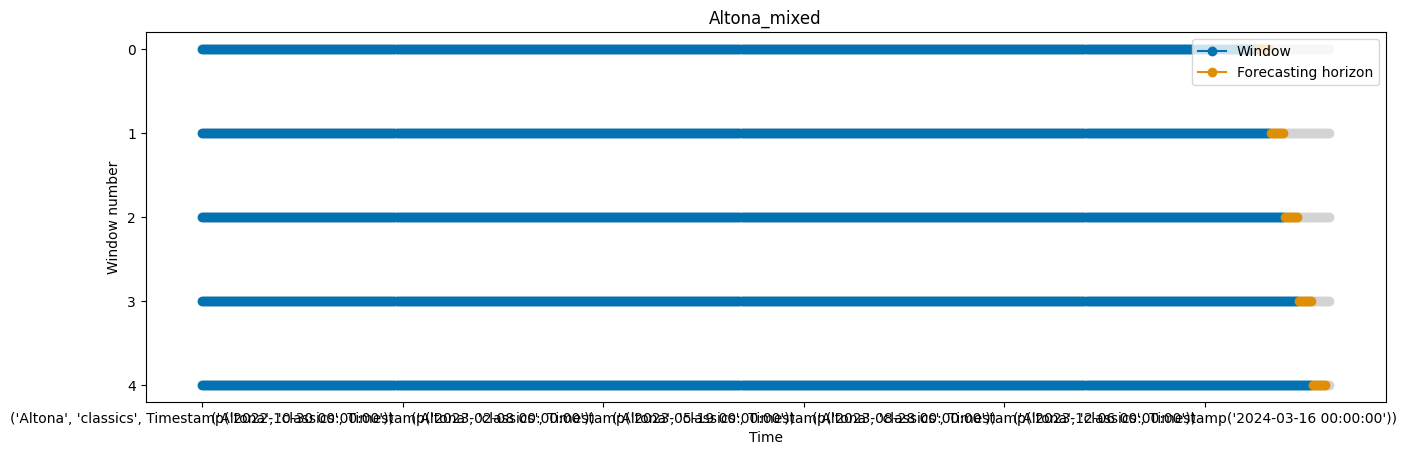

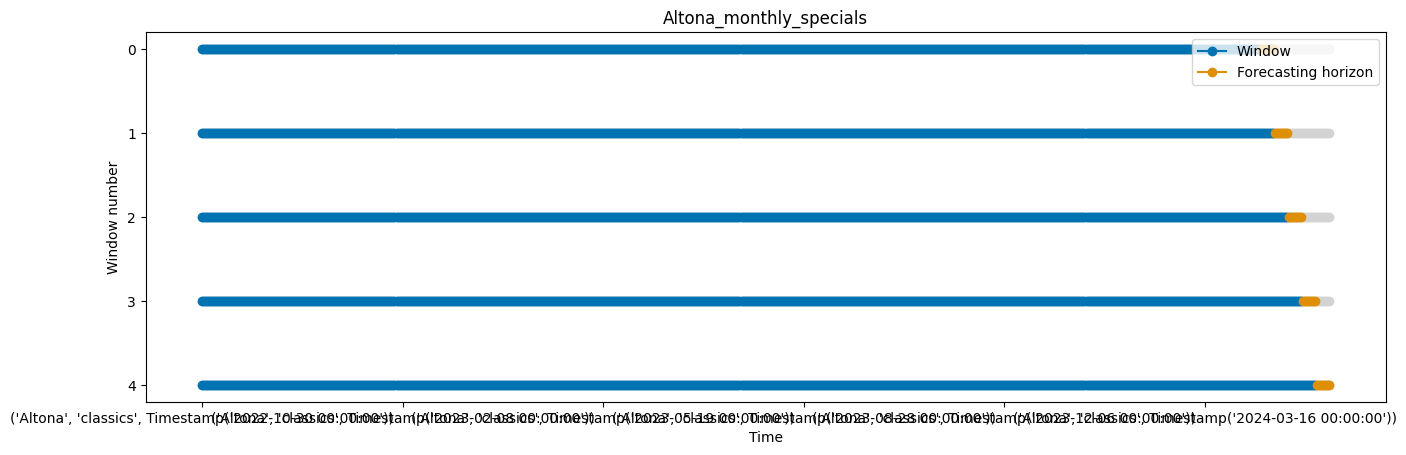

In [155]:
for i in range(3):
    plot_windows(list(cv_list[i][0].values())[0], list(cv_list[0][1].values())[0], 
                 title = list(cv_list[i][0].keys())[0])

In [156]:
model = cb.CatBoostRegressor(cat_features=catfeat)
forecaster = make_reduction(estimator = model, strategy="recursive", window_length = 7)

In [193]:
params = {
    'n_estimators': np.arange(500,5001,1, dtype="int32"),
    "learning_rate": np.logspace(-4, -1, dtype="float16"),
    "l2_leaf_reg": np.linspace(2, 30, dtype="float16"),
    "depth":np.arange(3,32,1, dtype="int32"),
    "subsample": np.linspace(0.05, 1.0, dtype="float16"),
    "colsample_bylevel": np.linspace(0.05, 1.0, dtype="float16"),
    "min_data_in_leaf": np.arange(10, 101, 1, dtype="int32"),
    "max_leaves": np.arange(10,41,1, dtype="int32")}

In [194]:
rscv_list = []

for i in range(len(cv_list)):
    rscv = ForecastingRandomizedSearchCV(forecaster = forecaster, 
                                         cv = list(cv_list[i][0].values())[0], 
                                         param_distributions=params, strategy="refit", n_iter=10)
    

    rscv_list.append({f"rscv_{list(cv_list[i][1].keys())[0]}":rscv})

In [196]:
fit_cv_list = []

for i in range(len(rscv_list)-35):
    fitted_cv = list(rscv_list[i].values())[0].fit(y = y_train_2_wind, X = x_train_2_wind)

    fit_cv_list.append({f"rscv_{list(rscv_list[i].keys())[0]}":fitted_cv})

OverflowError: Python int too large to convert to C long

In [ ]:
model = cb.CatBoostRegressor(cat_features=catfeat)

In [ ]:
randomized_search_result = model.randomized_search(params,
                                                  # n_iter=30,
                                                   X= x_train_daily,
                                                   y= y_train_daily,
                                                   cv = create_train_validation_folds(train_daily),
                                                   plot=True,
                                                   verbose = 500,
                                                   calc_cv_statistics=True)

In [ ]:
pd.DataFrame(randomized_search_result.get("cv_results"))

In [ ]:
randomized_search_result.get("params")

In [ ]:
#def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 3000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.1, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 2, 30),
        "depth": trial.suggest_int("depth", 1, 20),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "min_child_weight": trial.suggest_int(1, 300)
    }

    model = CatBoostRegressor(**params, silent=True, allow_writing_files = False, cat_features = catfeat)

    model_cv = optuna.integration.OptunaSearchCV(estimator = model, param_distributions = params, cv = create_train_validation_folds(train_daily), n_jobs = -1, n_trials = 30)
    
    #model.fit(x_train_daily, y_train_daily, eval_set = (create_train_validation_folds_cat(x_train_daily_totalamount)), cat_features = catfeat, verbose = 1000, plot = False)

    # y_val_pred_daily = model_cv.predict(x_val_daily)
    
    #rmse = mean_squared_error(y_val_daily, y_val_pred_daily, squared=False)

    #return rmse

#study = optuna.create_study(direction='minimize')
#study.optimize(objective, n_trials=30)

In [ ]:
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

In [ ]:
# Best model

model = CatBoostRegressor(n_estimators = 2620, learning_rate = 0.0487,
 depth = 5, subsample = 0.21, colsample_bylevel = 0.2, min_data_in_leaf = 21, early_stopping_rounds = 69, cat_features = catfeat, random_state = 123, allow_writing_files = True)

model.fit(x_train_daily, y_train_daily, eval_set=(x_val_daily, y_val_daily), verbose = 500, plot = True)

### Feature importances

In [ ]:
model.get_feature_importance(prettified=True).plot(x = "Feature Id", y = "Importances", kind = "bar")

### Evaluation metrics train and validation set

In [ ]:
y_train_pred = model.predict(x_train_daily)
print(f"R-squared train: {round(r2_score(y_train_daily, y_train_pred),6)}")
print(f"MAPE train: {round(100*mean_absolute_percentage_error(y_train_daily, y_train_pred),2)}\n")

y_val_pred = model.predict(x_val_daily)
print(f"R-squared validation: {round(r2_score(y_val_daily, y_val_pred),6)}")
print(f"MAPE validation: {round(100*mean_absolute_percentage_error(y_val_daily, y_val_pred),2)}")

# Test dataset

In [ ]:
x_test_daily_totalamount, y_test_pred =  pred_test(train = x_train_daily_totalamount, test = x_test_daily_totalamount, model = model, numfeat = numfeat, catfeat = catfeat)

### Residuals by store

In [ ]:
difference_df = diff_overview(data = x_test_daily_totalamount, pred = y_test_pred, stores = all)

### Residual Plot Analysis 

In [ ]:
sns.scatterplot(data = difference_df, x = "Predicted", y = "Stand_resid")

plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Sales (Daily total)")
plt.ylabel("Standardized Residuals")

plt.show()

### Evaluation metrics train and test set

In [ ]:
fit_overview(ytrain = y_train_daily, ytrainpred = y_train_pred, ytest = y_test_daily, ytestpred = y_test_pred)

In [ ]:
mape_stores(x_test_daily_totalamount, y_test_pred)

### Visualisation of predictions

In [ ]:
df_predicted = pd.concat(
    [
    difference_df[["Date","Store name","Observed","Predicted"]].rename(columns = {"Date":"date","Store name":"store_name","Observed":"total_amount"}),
    d[(d["date"] >= pd.to_datetime("2024-05-01")) & (d["item_category"] == "daily total")][["date","store_name","total_amount"]]
    ]
    )

In [ ]:
ts_predicted(df_predicted)